In [1]:
# Welcome to your new notebook
# Type here in the cell editor to add code!
# Welcome to your new notebook
# Type here in the cell editor to add code!
# Welcome to your new notebook
# Type here in the cell editor to add code!
# Welcome to your new notebook
# Type here in the cell editor to add code!
df = spark.sql(""" select Account_Number,
Invoice_Number,ShipToState,
Product_Segment_Extnl_Cap_Disp,
Invoiced_Date,Item_Number,ShipToState,
Capital_Disp_Inv_Item,
DESCRIPTIONF,Product_Segment_Description,Item_Description 
from KPMG_Bronze.dbo.EDW_Conmed_Sales_Data_Mart""")
display(df)

StatementMeta(, 56d4b1aa-8296-48f1-8439-ce869e8ca4b4, 3, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 1f8cb836-a053-4dd0-9e4f-a93d57860496)

In [5]:
from pyspark.sql import functions as F

# Extract Year-Month
df = df.withColumn("YearMonth", F.date_format("Invoiced_Date", "yyyy-MM"))

# Count unique customers per month
customer_count_df = df.groupBy("YearMonth").agg(F.countDistinct("Account_Number").alias("Customer_Count"))

# Define window for previous month comparison
window_spec = Window.orderBy("YearMonth")

# Calculate previous month's customer count
customer_count_df = customer_count_df.withColumn("Prev_Customer_Count", F.lag("Customer_Count").over(window_spec))

# Compute Growth Percentage
customer_count_df = customer_count_df.withColumn(
    "Growth_Percentage",
    F.when(F.col("Prev_Customer_Count").isNotNull(),
           ((F.col("Customer_Count") - F.col("Prev_Customer_Count")) / F.col("Prev_Customer_Count")) * 100)
    .otherwise(None)
)

# Show results
display(customer_count_df)

StatementMeta(, 56d4b1aa-8296-48f1-8439-ce869e8ca4b4, 7, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 343ca362-9eb3-497f-a1eb-264a3565facf)

In [4]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Extract Year-Month
df = df.withColumn("YearMonth", F.date_format("Invoiced_Date", "yyyy-MM"))

# Count unique customers per state per month
customer_count_df = df.groupBy("ShipToState", "YearMonth").agg(
    F.countDistinct("Account_Number").alias("Customer_Count")
)

# Define window partitioned by state and ordered by month
window_spec = Window.partitionBy("ShipToState").orderBy("YearMonth")

# Get previous month's customer count per state
customer_count_df = customer_count_df.withColumn(
    "Prev_Customer_Count", F.lag("Customer_Count").over(window_spec)
)

# Calculate growth percentage
customer_count_df = customer_count_df.withColumn(
    "Growth_Percentage",
    F.when(F.col("Prev_Customer_Count").isNotNull(),
           ((F.col("Customer_Count") - F.col("Prev_Customer_Count")) / F.col("Prev_Customer_Count")) * 100)
    .otherwise(None)
)

# Show results
#customer_count_df.orderBy("ShipToState", "YearMonth").show()
display(customer_count_df.orderBy("ShipToState", "YearMonth"))

StatementMeta(, 56d4b1aa-8296-48f1-8439-ce869e8ca4b4, 6, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, ab634221-68c0-4e1c-af72-2ba1339af598)

In [6]:
display(df.select("ShipToState").distinct())

StatementMeta(, 56d4b1aa-8296-48f1-8439-ce869e8ca4b4, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 00d03391-9c69-4e0a-938a-db58abcfbb0b)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Convert to Pandas DataFrame
customer_growth_pdf = customer_count_df.toPandas()

# Convert 'YearMonth' to datetime for proper plotting
customer_growth_pdf['YearMonth'] = pd.to_datetime(customer_growth_pdf['YearMonth'])

# Plot for each state
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=customer_growth_pdf,
    x='YearMonth',
    y='Growth_Percentage',
    hue='ShipToState',  # Different colors for each state
    marker='o'
)

# Graph labels
plt.title("Customer Growth Percentage by State Over Time")
plt.xlabel("Month")
plt.ylabel("Growth Percentage (%)")
plt.xticks(rotation=45)
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)

# Show plot
plt.show()


StatementMeta(, 56d4b1aa-8296-48f1-8439-ce869e8ca4b4, 10, Finished, Available, Finished)

ValueError: Could not interpret value `ShipToState` for parameter `hue`

In [14]:
# Get top 5 states with highest total customer count
top_states = (
    customer_growth_pdf.groupby("ShipToState")["Customer_Count"]
    .sum()
    .nlargest(5)
    .index
)

# Filter the dataset
filtered_data = customer_growth_pdf[customer_growth_pdf["ShipToState"].isin(top_states)]

# Plot only these top 5 states
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x='YearMonth', y='Growth_Percentage', hue='ShipToState', marker='o')

plt.title("Customer Growth Percentage (Top 5 States)")
plt.xlabel("Month")
plt.ylabel("Growth Percentage (%)")
plt.xticks(rotation=45)
plt.legend(title="State")
plt.grid(True)

plt.show()


StatementMeta(, 56d4b1aa-8296-48f1-8439-ce869e8ca4b4, 16, Finished, Available, Finished)

ValueError: Could not interpret value `YearMonth` for parameter `x`

In [11]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Extract Year and Quarter (e.g., "2024-Q1")
df = df.withColumn("YearQuarter", 
                   F.concat(F.year("Invoiced_Date"), F.lit("-Q"), F.quarter("Invoiced_Date")))

# Count unique customers per state per quarter
customer_count_df = df.groupBy("ShipToState", "YearQuarter").agg(
    F.countDistinct("Account_Number").alias("Customer_Count")
)

# Define window partitioned by state and ordered by quarter
window_spec = Window.partitionBy("ShipToState").orderBy("YearQuarter")

# Get previous quarter's customer count per state
customer_count_df = customer_count_df.withColumn(
    "Prev_Customer_Count", F.lag("Customer_Count").over(window_spec)
)

# Calculate growth percentage
customer_count_df = customer_count_df.withColumn(
    "Growth_Percentage",
    F.when(F.col("Prev_Customer_Count").isNotNull(),
           ((F.col("Customer_Count") - F.col("Prev_Customer_Count")) / F.col("Prev_Customer_Count")) * 100)
    .otherwise(None)
)

# Show results
display(customer_count_df.orderBy("ShipToState", "YearQuarter"))



StatementMeta(, e3d5be0e-fcef-4feb-b21c-672d015a767e, 13, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, afe81124-2705-4346-8632-fe72ad710e0d)

StatementMeta(, 56d4b1aa-8296-48f1-8439-ce869e8ca4b4, 15, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


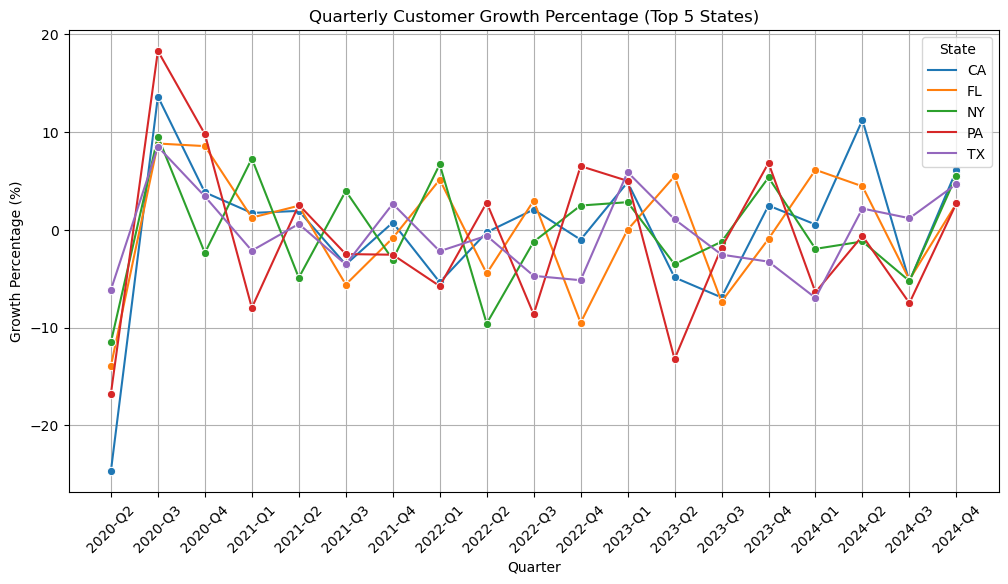

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert to Pandas for visualization
customer_growth_pdf = customer_count_df.toPandas()

# Ensure 'YearQuarter' is categorical and sorted properly
customer_growth_pdf['YearQuarter'] = pd.Categorical(customer_growth_pdf['YearQuarter'],
                                                    ordered=True, 
                                                    categories=sorted(customer_growth_pdf['YearQuarter'].unique()))

# Filter Top 5 States by Total Customers
top_states = customer_growth_pdf.groupby("ShipToState")["Customer_Count"].sum().nlargest(5).index
filtered_data = customer_growth_pdf[customer_growth_pdf["ShipToState"].isin(top_states)]

# Plot quarterly growth for top 5 states
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x="YearQuarter", y="Growth_Percentage", hue="ShipToState", marker="o")

plt.title("Quarterly Customer Growth Percentage (Top 5 States)")
plt.xlabel("Quarter")
plt.ylabel("Growth Percentage (%)")
plt.xticks(rotation=45)
plt.legend(title="State")
plt.grid(True)

plt.show()


In [12]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Convert Invoice_Date to quarterly representation if not already done:
df = df.withColumn(
    "YearQuarter", 
    F.concat(F.year("Invoiced_Date"), F.lit("-Q"), F.quarter("Invoiced_Date"))
)

# Count unique customers per state per quarter
customer_count_df = df.groupBy("ShipToState", "YearQuarter").agg(
    F.countDistinct("Account_Number").alias("Customer_Count")
)

# Define a window partitioned by state ordered by YearQuarter
window_spec = Window.partitionBy("ShipToState").orderBy("YearQuarter")

# Calculate previous quarter's customer count
customer_count_df = customer_count_df.withColumn(
    "Prev_Customer_Count", F.lag("Customer_Count").over(window_spec)
)

# Calculate Growth Percentage for each state/quarter
customer_count_df = customer_count_df.withColumn(
    "Growth_Percentage",
    F.when(F.col("Prev_Customer_Count").isNotNull(),
           ((F.col("Customer_Count") - F.col("Prev_Customer_Count")) / F.col("Prev_Customer_Count")) * 100)
    .otherwise(None)
)

# Optional: Filter out quarters with no previous data (first quarter per state)
customer_count_df = customer_count_df.filter(F.col("Growth_Percentage").isNotNull())

display(customer_count_df.orderBy("ShipToState", "YearQuarter"))


StatementMeta(, 56d4b1aa-8296-48f1-8439-ce869e8ca4b4, 14, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 77f7b345-5df5-4afd-9eeb-f96880987806)

In [15]:
# Aggregate by quarter across states
aggregate_quarterly = customer_count_df.groupBy("YearQuarter").agg(
    F.avg("Growth_Percentage").alias("Avg_Growth_Percentage"),
    F.count("ShipToState").alias("Total_States"),
    F.sum(F.when(F.col("Growth_Percentage") > 0, 1).otherwise(0)).alias("Growing_States"),
    F.sum(F.when(F.col("Growth_Percentage") < 0, 1).otherwise(0)).alias("Declining_States")
)

# Calculate percentage of states growing and declining
aggregate_quarterly = aggregate_quarterly.withColumn(
    "Pct_Growing", F.col("Growing_States") / F.col("Total_States") * 100
).withColumn(
    "Pct_Declining", F.col("Declining_States") / F.col("Total_States") * 100
)

display(aggregate_quarterly.orderBy("YearQuarter"))


StatementMeta(, 56d4b1aa-8296-48f1-8439-ce869e8ca4b4, 17, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 58b58971-352a-4bfe-b95e-44e7ee2f6ed0)

StatementMeta(, 56d4b1aa-8296-48f1-8439-ce869e8ca4b4, 18, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_ol

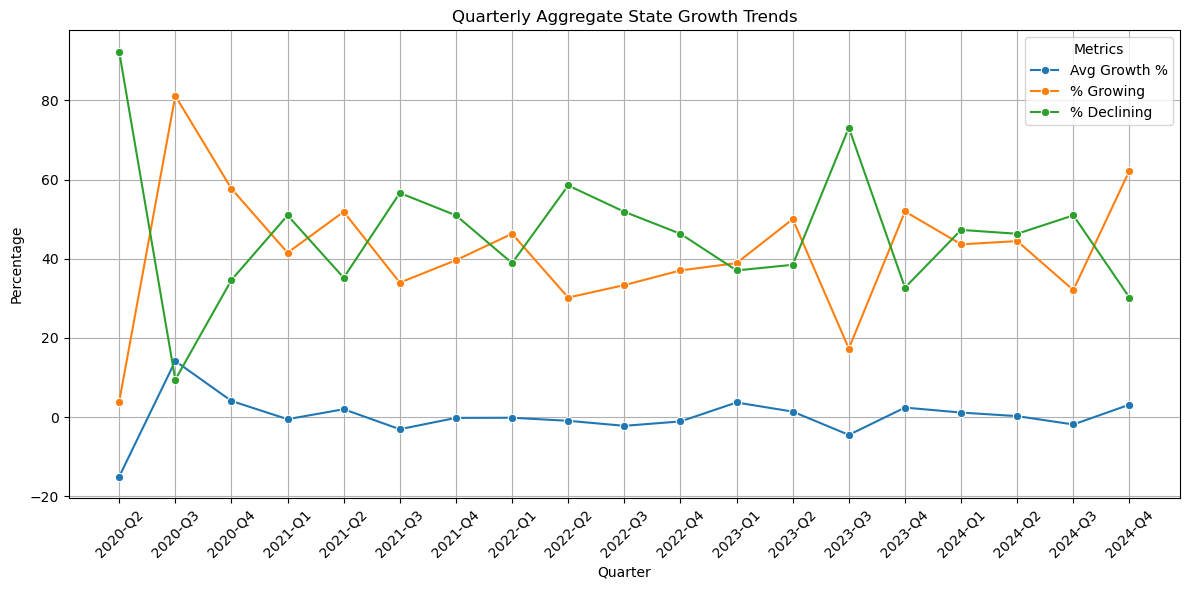

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame
agg_pd = aggregate_quarterly.orderBy("YearQuarter").toPandas()

# If YearQuarter is a string like "2023-Q1", we may sort them manually or assume they are sorted.
# Here, we can use them as categorical variables if needed.

plt.figure(figsize=(12, 6))

# Plot average growth percentage
sns.lineplot(data=agg_pd, x='YearQuarter', y='Avg_Growth_Percentage', marker='o', label='Avg Growth %')

# Plot percentage of states growing and declining
sns.lineplot(data=agg_pd, x='YearQuarter', y='Pct_Growing', marker='o', label='% Growing')
sns.lineplot(data=agg_pd, x='YearQuarter', y='Pct_Declining', marker='o', label='% Declining')

plt.title("Quarterly Aggregate State Growth Trends")
plt.xlabel("Quarter")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.grid(True)
plt.tight_layout()
plt.show()


StatementMeta(, 56d4b1aa-8296-48f1-8439-ce869e8ca4b4, -1, Finished, Available, Finished)